In [ ]:
from tardis_em.utils.load_data import load_image

path = '../../../../Downloads/GridA1_section1_crop_semantic.mrc'
img, px = load_image(path)

path = '../../../../Downloads/GridA1_section1_crop_semantic_auto.mrc'
img_auto, px = load_image(path)

In [ ]:
from tardis_em.dist_pytorch.utils.build_point_cloud import BuildPointCloud

post_processes = BuildPointCloud()

pc_hd, pc_ld = post_processes.build_point_cloud(
                    image=img, down_sampling=5
                )

pc_hd_auto, pc_ld_auto = post_processes.build_point_cloud(
                    image=img_auto, down_sampling=5
                )



In [ ]:
import numpy as np
pc_ld = np.hstack((np.zeros(len(pc_ld))[:, np.newaxis], pc_ld))
pc_ld_auto = np.hstack((np.zeros(len(pc_ld_auto))[:, np.newaxis], pc_ld_auto))


In [ ]:
import pandas as pd

segments = pd.DataFrame(pc_ld)
segments.to_csv(
    '../../../../Downloads/GridA1_section1_crop_semantic.csv',
    header=["IDs", "X [A]", "Y [A]", "Z [A]"],
    index=False,
    sep=",",
)

segments = pd.DataFrame(pc_ld_auto)
segments.to_csv(
    '../../../../Downloads/GridA1_section1_crop_semantic_auto.csv',
    header=["IDs", "X [A]", "Y [A]", "Z [A]"],
    index=False,
    sep=",",
)

In [ ]:
path = (
    "/Users/robertkiewisz/Desktop/test/231110_JanelTTLL11_212-800_100nM_010_no_salt.nd2"
)

extensions_points = (".csv",)

extensions_images = (".rec", ".mrc", ".tiff", ".tif", ".nd2", ".am")
path.endswith(extensions_images)

In [ ]:
import os
import numpy as np

path = "../../../tesing_data/TS_Dogic_800.mrc_16.56Apx_SpatialGraph_filter.am"
with open(path, "r") as f:
    df = next(f).split(" ")

if {"AS", "ASI"}.intersection(df):
    print(True)

In [ ]:
f.readline(-1)

In [ ]:
import torch


def get_available_devices():
    devices = ["cpu"]

    # Check if CUDA (NVIDIA GPU) is available and list all available CUDA devices
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            devices.append(f"cuda:{i}")

    # Check for MPS (Apple's Metal Performance Shaders) availability
    if torch.backends.mps.is_available():
        devices.append("mps")

    return devices

In [ ]:
get_available_devices()

In [ ]:
import numpy as np

data = np.genfromtxt(
    "../../../test/Predictions/231110_JanelTTLL11_212-800_100nM_010_no_salt_3_instances_filter.csv",
    skip_header=1,
    delimiter=",",
    dtype=np.float16,
)
unique_ids = np.unique(data[:, 0])

In [ ]:
from os.path import splitext, basename

path = "../../../test/Predictions/231110_JanelTTLL11_212-800_100nM_010_no_salt_3_instances_filter.csv"
splitext(basename(path))[0]

In [ ]:
data = data[:, 1:]
data = np.vstack((data[:, 2], data[:, 1], data[:, 0])).T
data

In [ ]:
from tardis_em.utils.load_data import load_nd2_file
import os

dirs_ = "../../../../Downloads/MTs_TIRF/"
paths = [i for i in os.listdir(dirs_) if i.endswith(".nd2")]

# nd2, _ = load_nd2_file(os.path.join(dirs_, paths[0]), )

nd2_ = []
for i in paths:
    nd2, _ = load_nd2_file(
        os.path.join(dirs_, i),
    )
    nd2_.append(nd2)

In [ ]:
paths[7]

In [ ]:
for i in nd2_:
    print(i.shape)

In [ ]:
import matplotlib.pyplot as plt

i = 7
print(nd2_[i].shape)
plt.imshow(nd2_[i][0, 0, 0, ...], cmap="gray")

In [ ]:
import numpy as np

np.mean(nd2_[i][0, 0, 0, ...]) / np.std(nd2_[i][0, 0, 0, ...])

In [ ]:
from tardis_em.utils.visualize_pc import show_image_list

show_image_list([i for i in nd2])

In [ ]:
from tardis_em.utils.load_data import load_image
import matplotlib.pyplot as plt


img, px = load_image("../../../ht_example/10805/g3_MMM1_TS1_dose-filt.rec")
print(px)
plt.figure(dpi=300)
# plt.axis('off')
plt.hist(img.flatten())

In [ ]:
import scipy
import numpy as np
from tardis_em.utils.normalization import RescaleNormalize, MeanStdNormalize
norm = RescaleNormalize((.1, 99.9))
mstd = MeanStdNormalize()

init_frame = mstd(norm(img[1, 0, 0, ...]))
curr_frame = mstd(norm(img[1, 0, 1, ...]))

# init_frame = init_frame - np.mean(init_frame)
# curr_frame = curr_frame - np.mean(curr_frame)

# calculate the correlation image; note the flipping of onw of the images
shift = scipy.signal.fftconvolve(init_frame, curr_frame[::-1,::-1], mode='full')
np.unravel_index(np.argmax(shift), shift.shape)

In [ ]:
(924//2, 1506//2)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(shift, cmap="gray")

In [ ]:
from tardis_em.utils.load_data import load_image
from tardis_em.utils.visualize_pc import show_image_list

img, px = load_image(
    "../../../test_tirf/movie/2024-10-14_TTLL11_212-800_100nM_005.nd2")


In [ ]:
from tardis_em.analysis.geometry_metrics import total_length, thicken_line_coordinates, pixel_intensity
from scipy.interpolate import splprep, splev


def co_localize_tirf(image: np.ndarray, filaments: np.ndarray, channel_in: int, thickness: int, name: str):
    """
    - Get all channels, and dim_ as a channel to which we colocalizing
    - get thicness from bt1 and bt2 as the bigger one
    - for each MT
        - extract MT track on all channels
        - Compute co-localized signal between all channels
        - append resoults
    Args:
        image (np.ndarray): image data of shape (C, T, H, W) or (C, H, W)
    """
    channels = [i for i in range(image.shape[0]) if i != channel_in]
    if image.ndim == 4:
        C, T, H, W = image.shape
    else:
        C, H, W = image.shape
        T = None

    colocalized_data_mean = []
    for i in np.unique(filaments[:, 0]):
        tck, u = splprep(data.T, s=0)

        data_fine = np.linspace(0, 1, 2 * int(total_length(data)))
        data_fine = np.array(splev(data_fine, tck)).T

        pixel_coords = np.rint(data_fine).astype(int)
        pixel_coords = np.unique(pixel_coords, axis=0)
        pixel_coords = thicken_line_coordinates(pixel_coords, thickness)

        if T is None:
            intensity_ch_in = pixel_intensity(pixel_coords, image[channel_in, ...])
            intensity_ch_out = []
            for i in channels:
                intensity_ch_out.append(pixel_intensity(pixel_coords, image))


In [ ]:
from napari_tardis_em.viewers.utils import frames_phase_correlation

for i in range(img.shape[1]):
    img[1, i, ...] = frames_phase_correlation(img[1, i, ...])

In [ ]:
from napari_tardis_em.viewers.utils import frames_phase_correlation

frames_cor = frames_phase_correlation(frames)

In [ ]:
import tifffile.tifffile as tif
import numpy as np
# tif.imwrite('../../../test_tirf/movie/frames.tif', frames)
tif.imwrite('../../../test_tirf/movie/frames_cor.tif', img)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(frames.flatten())

In [ ]:
plt.hist(frames_cor.flatten())

In [ ]:
strings='0.5'
strings = strings.replace(',', '.') if ',' in strings else strings
float(strings)


In [1]:
from tardis_em.analysis.spatial_graph_utils import FilterSpatialGraph
import numpy as np

segments = np.genfromtxt('../../../test_tirf/movie/Predictions/2024-10-14_TTLL11_212-800_100nM_005_0_instances.csv', delimiter=',')[1:, ...]

filter_splines = FilterSpatialGraph(
                        connect_seg_if_closer_then=25,
                        cylinder_radius=12,
                        filter_short_segments=10,
                    )
segments_filter = filter_splines(segments=segments, px=None)


In [2]:
from tardis_em.utils.visualize_pc import VisualizePointCloud
VisualizePointCloud(segments_filter, True)

NameError: name 'o3d' is not defined

In [4]:
from tardis_em.utils.load_data import load_nd2_file
import numpy as np

img, px = load_nd2_file('/Users/robertkiewisz/Desktop/test_tirf/2024-10-21_ChL_TTLL11_212-800_100nM_022.nd2')
img = img[:, 1, 0, ...]

coord = np.genfromtxt('/Users/robertkiewisz/Desktop/test_tirf/Predictions/2024-10-21_ChL_TTLL11_212-800_100nM_022_0_instances_filter.csv', delimiter=',', skip_header=1)

In [5]:
from tardis_em.analysis.geometry_metrics import calculate_spline_correlations

correlations, correlations_px = calculate_spline_correlations(img, coord, frame_id=1, thickness=[1, 1])

In [7]:
correlations_px[0]['MT']

{0: [0.45654916763305664,
  0.4308215379714966,
  0.42728400230407715,
  0.43017834424972534,
  0.4478660821914673,
  0.4740760922431946,
  0.40380755066871643,
  0.3954460918903351,
  0.45670995116233826,
  0.4499564468860626,
  0.4250328242778778,
  0.46571460366249084,
  0.44304215908050537,
  0.4049331545829773,
  0.4171537458896637,
  0.4021995961666107,
  0.4231032729148865,
  0.46716180443763733,
  0.46748340129852295,
  0.4509212374687195,
  0.4248720407485962,
  0.4973917603492737,
  0.37968793511390686,
  0.5105771422386169,
  0.4387006163597107,
  0.4478660821914673,
  0.384994238615036,
  0.48597511649131775,
  0.4123298227787018,
  0.4803471863269806,
  0.4790608286857605,
  0.5211897492408752,
  0.47954320907592773,
  0.43226873874664307,
  0.44561493396759033,
  0.5129891037940979,
  0.48613590002059937,
  0.46780499815940857,
  0.41811853647232056,
  0.508004367351532,
  0.46089068055152893,
  0.5218329429626465,
  0.4081490933895111,
  0.5044668316841125,
  0.430017560

In [4]:
from tardis_em.analysis.analysis import analyse_filaments

anal = analyse_filaments(coord, img, [1, 1], )
anal[0]

[[106.34993111995266,
  112.14110332127784,
  118.15502886450389,
  138.33805463773695,
  146.09526767073763,
  150.64814574878147,
  151.55697223581257,
  154.54405596990892,
  169.87948688989962,
  175.03148894045069,
  179.5378426293858,
  181.57163709116887,
  210.24011813177836,
  213.26717965766898,
  226.94608610403708,
  248.63468350473497,
  268.4770484572618,
  273.2093895707732,
  293.4055440512225,
  296.2113523432957,
  328.53569420587945,
  353.63979952962984,
  365.2846557981258,
  426.8074871584455,
  493.1322938796223,
  1149.301180235087]]

In [6]:
import pandas as pd

# Assuming your dictionary is called 'data'
def convert_dict_to_csv(data, filename='output.csv'):
    # Prepare a dictionary to store our columns
    csv_data = {}

    # Iterate through the main dictionary
    for main_key in data:
        # Add reference column
        csv_data[f"{main_key}_reference"] = data[main_key]["reference"]

        # Add MT columns
        for mt_key in data[main_key]["MT"]:
            csv_data[f"{main_key}_MT_{mt_key}"] = data[main_key]["MT"][mt_key]

    # Find the maximum length of all lists to ensure proper DataFrame creation
    max_length = max(len(lst) for col in csv_data.values() for lst in [col])

    # Pad shorter lists with None to make them equal length
    for col in csv_data:
        current_length = len(csv_data[col])
        if current_length < max_length:
            csv_data[col].extend([None] * (max_length - current_length))

    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data)
    df.to_csv(filename, index=False)


convert_dict_to_csv(correlations_px, '/Users/robertkiewisz/Desktop/test_tirf/correlations.csv')

In [14]:
import numpy as np

analysis_file = np.zeros((28, 12))
anal_list = [ "length", "avg_intensity",  "avg_length_intensity", "correlation"]
df = {
    "length": 3,
    "curvature": 4,
    "tortuosity": 5,
    "avg_intensity": 6,
    "avg_length_intensity": 7,
    "sum_intensity": 8,
    "sum_length_intensity": 9
}

keep_ = [0, 1, 2] + [df[i] for i in anal_list if i in df]
if "correlation" in anal_list:
    keep_ = keep_ + [10]

remove_ = [item for item in list(range(analysis_file.shape[1])) if item not in keep_]

if 10 in keep_:
    keep = keep_.extend([i for i in remove_ if i > 10])
    remove_ = [i for i in remove_ if i < 10]

analysis_file = np.delete(analysis_file, remove_, axis=1)

header = [
                "File_Name",
                "No. of Filament",
                "Pixel_Size [nm]",
                "Length [nm]",
                "Curvature [0-inf]",
                "Tortuosity [1-inf]",
                "Avg. Intensity [U]",
                "Avg. Intensity / Length [U/nm]",
                "Sum. Intensity [U]",
                "Sum. Intensity / Length [U/nm]",
            ]
header = header + [f"Correlation [Pearson] CH_{i}" for i in range(2)]
header = [h for id, h in enumerate(header) if id in keep_]

In [102]:
from tardis_em.utils.load_data import ImportDataFromAmira

am = ImportDataFromAmira("/Users/robertkiewisz/Desktop/tomo_reconstruction_imod/Done/T0635_U2OS_9D_cell1_01_filtered_kmts.am")
coord = am.get_segmented_points()
px = 25.72

coord[:, 1:] = coord[:, 1:] / 10000

In [103]:
from tardis_em.analysis.geometry_metrics import length_list

lenght = length_list(coord)

In [104]:
import numpy as np

print(f"{np.round(np.mean(lenght), 2)} ±{np.round(np.std(lenght), 2)}")

3.39 ±1.74


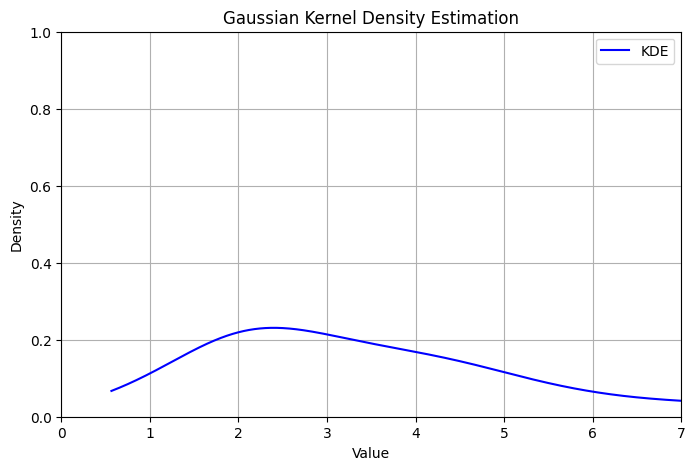

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate some sample data

# Calculate KDE
kde = gaussian_kde(lenght)

# Create a range of values over which to evaluate the KDE
x_vals = np.linspace(min(lenght), max(lenght), 1000)
kde_vals = kde(x_vals)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, kde_vals, label='KDE', color='blue')
plt.ylim(0, 1)
plt.xlim(0, 7)
# plt.hist(lenght, bins=30, density=True, alpha=0.4, label='Histogram')
plt.title('Gaussian Kernel Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

(array([ 6.,  5.,  9.,  2., 11., 12., 12.,  5.,  5.,  7.,  8.,  7., 13.,
        17.,  4.,  6., 16.,  6.,  9., 11.,  7., 11.,  7., 14., 11., 13.,
        12., 10., 13., 15., 16., 18., 15., 12., 16., 13., 15., 20., 22.,
        25., 12., 18., 23., 21., 22., 17., 18., 17., 17., 27., 37., 29.,
        15., 21., 24., 20., 30., 26., 32., 18., 15., 26., 17., 22., 20.,
        16., 19.,  9., 18., 10., 12.,  7., 10., 12., 14., 11.,  7., 16.,
        13.,  6.,  9.,  7.,  5.,  0.,  3.,  5.,  5.,  2.,  0.,  2.,  3.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([0.06174744, 0.1301499 , 0.19855236, 0.26695482, 0.33535728,
        0.40375974, 0.4721622 , 0.54056467, 0.60896713, 0.67736959,
        0.74577205, 0.81417451, 0.88257697, 0.95097943, 1.01938189,
        1.08778435, 1.15618681, 1.22458928, 1.29299174, 1.3613942 ,
        1.42979666, 1.49819912, 1.56660158, 1.63500404, 1.7034065 ,
        1.77180896, 1.84021143, 1.90861389, 1.97701635, 2.04541881,
        2.11382127, 2.1822

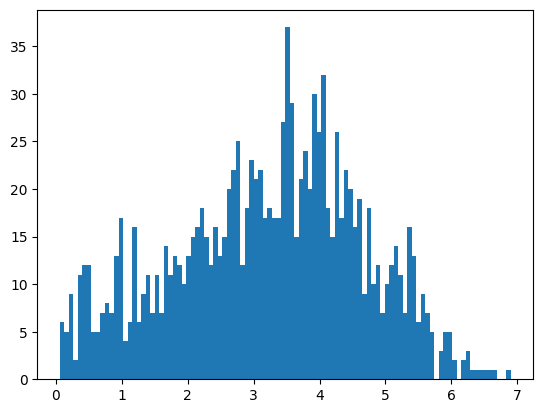

In [78]:
import matplotlib.pyplot as plt

plt.hist(lenght, bins=100)

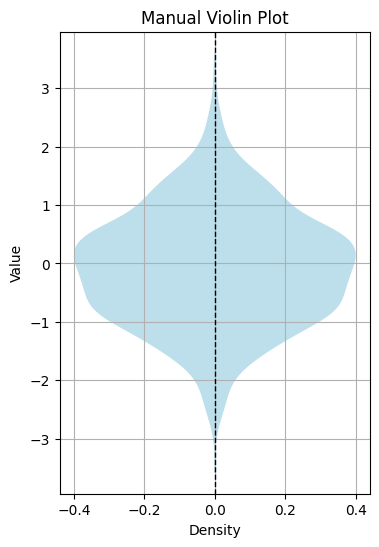

In [88]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.random.normal(0, 1, 1000)

# KDE
kde = gaussian_kde(data)
y = np.linspace(min(data), max(data), 500)
density = kde(y)

# Normalize for better scaling in plot
density = density / density.max() * 0.4  # scale for width of the "violin"

# Plot mirrored KDE (violin)
plt.figure(figsize=(4, 6))
plt.fill_betweenx(y, -density, density, facecolor='lightblue', alpha=0.8)
plt.axvline(0, color='black', linestyle='--', lw=1)
plt.title('Manual Violin Plot')
plt.xlabel('Density')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [1]:
from tardis_em.utils.load_data import ImportDataFromAmira

am = ImportDataFromAmira('/Users/robertkiewisz/Downloads/TestForRobert.am')

In [2]:
am.get_labels()

{'LabelGroup': array([0, 1, 4, 5]), 'LabelGroup2': array([2, 3, 4, 5])}